# Assignment 1: Computational Finance

In [4]:
import yfinance as yf
import datetime

ticker = "AAPL"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

data = yf.download(ticker, start = start_date, end = end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Historical Estimators

In [8]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440330,6.455076,6.391278,6.422876,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458086,601904800
2010-01-06,6.348847,6.477046,6.342226,6.451466,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800


In [6]:
mean_close = data['Close'].mean()
vol = data['Close'].std()
print(mean_close, vol)

Ticker
AAPL    70.049196
dtype: float64 Ticker
AAPL    68.174889
dtype: float64


In [10]:
import numpy as np # for the np.sqrt

In [27]:
sigma_parkinson = np.sqrt(1/(4*np.log(2))*np.sum(np.log(data["High"]/data["Low"])**2))

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [29]:
sigma_parkinson

Ticker
AAPL    0.864009
dtype: float64

In [26]:
T = (datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.datetime.strptime(start_date, "%Y-%m-%d")).days
print(T)

5568


In [30]:
sigma_garman_klass = np.sqrt(1/(2*T)*np.sum(np.log(data["High"]/data["Low"])**2) - (2*np.log(2)-1)/T*np.sum((np.log(data["Close"]/data["Open"]))**2))

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [31]:
sigma_garman_klass

Ticker
AAPL    0.011647
dtype: float64

In [85]:
def sigma_parkinson_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        1/(4*np.log(2))*np.sum(np.log(_high/_low)**2)
        )

In [86]:
def sigma_garman_klass_estimator(_high, _low, _open, _close, T):
    return np.sqrt(
        (1/(2*T))*np.sum(np.log(_high/_low)**2) - 
        ((2*np.log(2)-1)/T) * np.sum((np.log(_close/_open))**2)
        )

In [87]:
# We now compute a rolling window estimator using a 30-day window for normal sigma, sigma parkinson and sigma garman klass

import pandas as pd
import numpy as np

def rolling_window(data, window):
    return data.rolling(window).mean()

data_rw30 = rolling_window(data, 30)

Should we dropna()?

In [82]:
data_rw30.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN


In the rolling window estimator does T change?

In [90]:
sigma_gk = [sigma_garman_klass_estimator(
            data_rw30["High"][t:], data_rw30["Low"][t:], data_rw30["Open"][t:], data_rw30["Close"][t:], T-t
            ) for t in range(T)]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [93]:
sigma_p = [sigma_parkinson_estimator(
    data_rw30["High"][t:], data_rw30["Low"][t:], data_rw30["Open"][t:], data_rw30["Close"][t:], T-t
) for t in range(T)]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


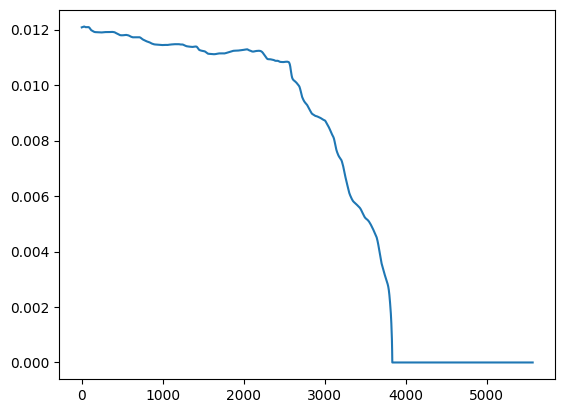

In [95]:
import matplotlib.pyplot as plt
# we plot sigma_gk and sigma_p over time

plt.plot(sigma_gk)
#plt.plot(sigma_p)
plt.show()

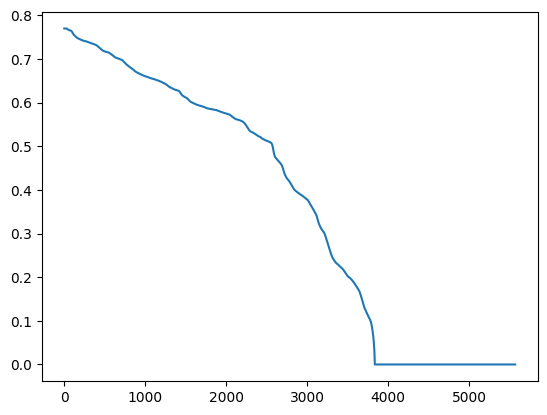

In [96]:
plt.plot(sigma_p)
plt.show()

In [ ]:
def volatility_signature_plot(m):
    grid = np.linspace(0, len(data)-1, m).astype(int)
    data_m = data.iloc[grid]
    sigma_gk = [
        sigma_garman_klass_estimator(data_m["High"][t:], data_m["Low"][t:], data_m["Open"][t:], data_m["Close"][t:]
                                     , T-t)
        for t in range(T)]
    sigma_p = [
        sigma_parkinson_estimator(data_m["High"][t:], data_m["Low"][t:], data_m["Open"][t:], data_m["Close"][t:]
                                  , T-t)
        for t in range(T)]
    GK = np.sum(sigma_gk)/T
    P = np.sum(sigma_p)/T
    return GK, P

GK_signature = [volatility_signature_plot(i)[0] for i in np.linspace(0, 1000, 5).astype(int)]
P_signature = [volatility_signature_plot(i)[1] for i in np.linspace(0, 1000, 5).astype(int)]


plt.plot(GK_signature)
plt.plot(P_signature)
plt.show()